##Assignment 1 - Implementation and application of online power PCA#

## Preamble
### Power PCA

In Lecture 4 we learned about the power method for PCA, which is based on the following iterative process
$$\mathbf{w}\leftarrow \mathbf{Rw}, \mathbf{w}\leftarrow\frac{\mathbf{w}}{\|\mathbf{w}\|}$$
that makes $\mathbf{w}$ converge to the (first) eigenvector. 
After obtaining the first eigenvector, the R matrix needs to be deflated:
$$ \mathbf{R} \leftarrow \mathbf{R} - \mathbf{ww}^T\mathbf{R}$$
With progressive deflation of $\mathbf{R}$, multiple eigenvectors can be worked out using the same process.

### Dataset
For this assignment we are using an image dataset Fashion-MNIST. This dataset is being promoted as a new benchmark (instead of MNIST) for a number of machine learning problems. We will work on a partial version of the dataset,  downloadable as a text file, "fashion-mnist_test.csv". It contains 10,000 rows of data, each row started with a class label ('0'-'9'), and followed by 784 (28x28) pixel values in grayscale. 

## Part 1. Visualization

**Task 1**. Use Pandas' utilities to load in the CSV file. Assign data and labels to different arrays. Plot out a few rows of data by showing them as 28x28 grayscale images. (1 mark)

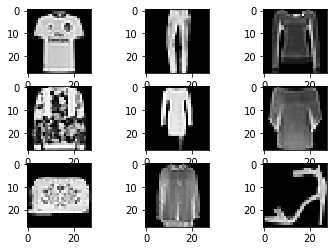

In [49]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
from PIL import Image
from sklearn.preprocessing import StandardScaler

label = pd.read_csv('fashion-mnist_test.csv', usecols = ['label'])
data = pd.read_csv('fashion-mnist_test.csv',usecols =range(1,785))
label.shape
data.shape
label.head()

x = np.array(label.values) ##labels converted into array
y = np.array(data.values) ##data converted into array




for i in range (9):
    pl.subplot(330 + 1 + i )
    pl.imshow(y[i].reshape(28,28).astype('uint8'),cmap=pl.get_cmap('gray'),interpolation = 'nearest')

pl.show()


In [26]:
label.head()
data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,9,8,0,...,103,87,56,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,0,63,53,31,0,0,0
3,0,0,0,0,0,0,0,0,0,161,...,137,126,140,0,133,224,222,56,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*For sake of efficiency you can subsample the data by 50% and use it for the following tasks.*

**Task 2**. Implement the power method and work out the first two eigenvectors using the dataset. Plot out a 2-D scatterplot of the projected data using the powerPCA() function. (3 marks)


Use different markers to differentiate data points of different classes. 

********************************************************************************
   1st_principal  2nd_principal  label
0      15.896569      -4.209624    0.0
1      -1.148177     -17.444886    1.0
2      -9.792718      -3.206820    2.0
3      10.415778       2.467272    2.0
4       2.906718     -10.894973    3.0
5      -1.383824      -0.783383    2.0
6       1.206075      21.419593    8.0
7       2.379019      -3.358427    6.0
8     -18.202331       2.614576    5.0
9      -2.299144     -10.040914    0.0


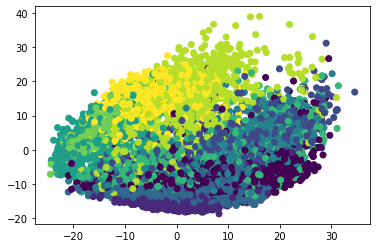

In [27]:
def eigenvalue(R,w):
    Rw = R.dot(w)
    return w.dot(Rw)

def powerPCA(R):
    n, d = R.shape
    w = np.ones(d) / np.sqrt(d) #eigen vector
    ev = eigenvalue(R, w)
    
    while True:
        Rw = R.dot(w)
        w_new = Rw / np.linalg.norm(Rw) #new eigenvector
        ev_new = eigenvalue(R, w_new) #new eigenvalue
        if np.abs(ev - ev_new) < 0.01:
            break
        w = w_new
        ev = ev_new
    return w_new, ev_new

standardized_data = StandardScaler().fit_transform(data)
#print(standardized_data.shape)  
X = standardized_data
R = np.matmul(X.T, X)  #finding co-variance matrix
w1,e1 = powerPCA(R)
w1 = w1.reshape(784, 1)
wr = np.matmul(w1, w1.T)
Rd = np.matmul(wr,R)
R2 = R-Rd
w2,e2= powerPCA(R2)
w1 = w1.reshape(784,)

E = np.vstack((w1,w2))
#print(E.shape)
Y=np.matmul(E, X.T)
#print(Y.shape)
Y =Y.T
Y = np.append(Y,label,axis=1)

#Y=np.vstack((Y,label)).T
#print(Y.shape)
pl.scatter(Y[:,0], Y[:,1], c=Y[:,2])

dataframe = pd.DataFrame(data = Y, columns=("1st_principal", "2nd_principal", "label"))
print("*"*80)
print(dataframe.head(10))
pl.show()

## Part 2. Online PCA using modified power method

The $\mathtt{powerPCA}$ method given above carries out PCA in a batch mode, i.e., it needs to gather all data to compute the covariance matrix $\mathbf{R}$, and then the power iterations follow (along with the deflation of $\mathbf{R}$ for each eigenvector obtained). 

The following is an idea about developing an incremental Power method for online analysis of data streams. 

First, use a mini-batch, say the first 100 rows of $\mathbf{X}$ to obtain the mean vector $\mathbf{m}$, and the covariance matrix $\mathbf{R}$ in the same way as in the $\mathtt{powerPCA()}$ method. Now, design an online Power Method algorithm that carries out the following operations:
1. Use the next row of $\mathbf{X}$ as input $\mathbf{x}$, and update the online average $\mathbf{m}$.
2. Use $\mathbf{x}$ to update $\mathbf{R}$ (as an online average of $\mathbf{x}^T\mathbf{x})$.
3. Write an $\mathtt{onlinePowerPCA(R)}$ method that derives the eigenvectors and eigenvalues of
the updated $\mathbf{R}$, using the current eigenvector as the initial $\mathbf{w}$.
4. Repeat the above process until all entries of $\mathbf{X}$ are handled.

Following the idea we introduced in online clustering, we can use the exponential weighting to produce the online average, e.g.
$$\mathbf{m}\leftarrow \mathbf{m}+ \gamma(\mathbf{x}-\mathbf{m})=(1-\gamma)\mathbf{m}+\gamma\mathbf{x}$$
where $\gamma$ is a weighting coefficient, $0<\gamma\ll 1$. The same idea works for updating $\mathbf{R}$ as well. 

**Task 3**. Use $\mathtt{onlinePowerPCA()}$ to visualize the dataset, generating PCA snapshots of the dataset upon processing every 500 data points. Compare the final visualization with that of Task 2. (2 marks)

batch size currently : 500


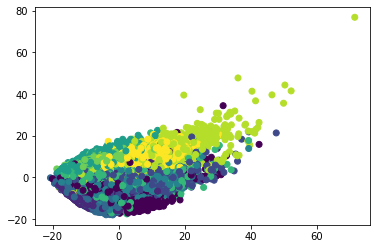

batch size currently : 1000


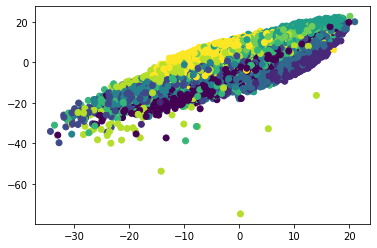

batch size currently : 1500


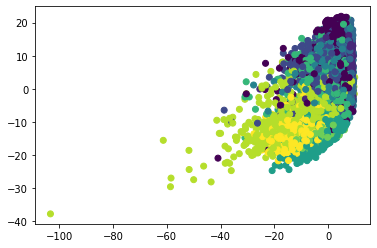

batch size currently : 2000


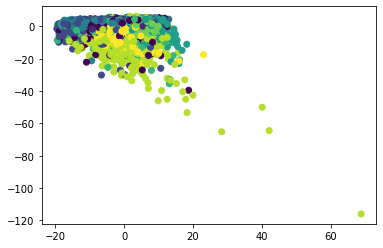

batch size currently : 2500


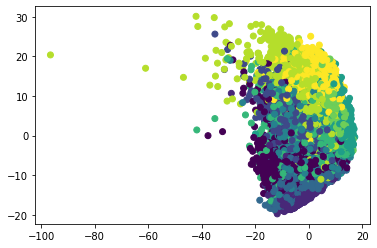

batch size currently : 3000


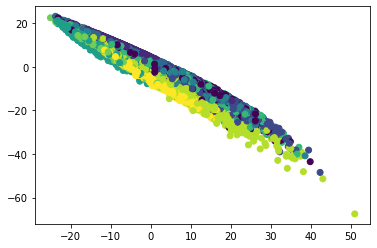

batch size currently : 3500


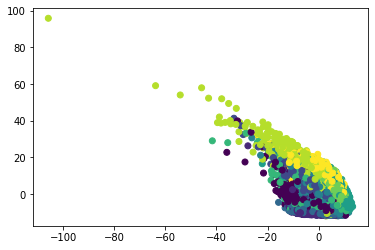

batch size currently : 4000


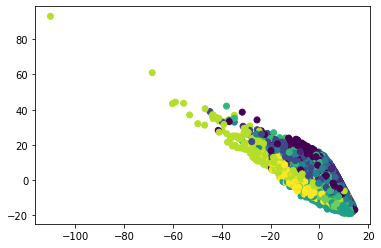

batch size currently : 4500


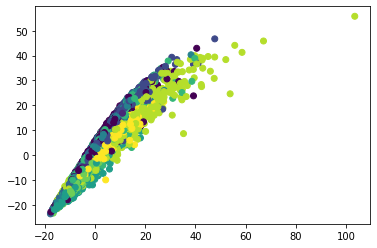

batch size currently : 5000


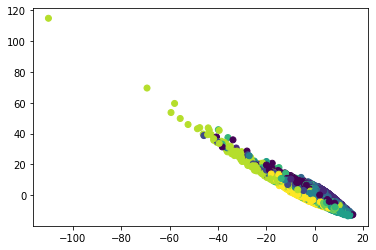

batch size currently : 5500


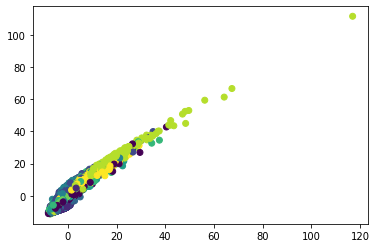

batch size currently : 6000


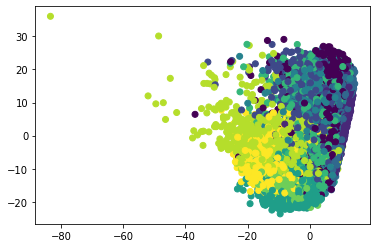

batch size currently : 6500


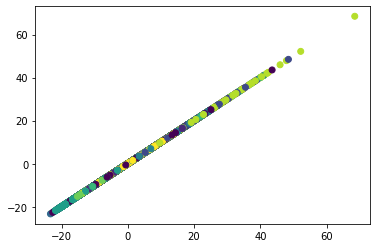

batch size currently : 7000


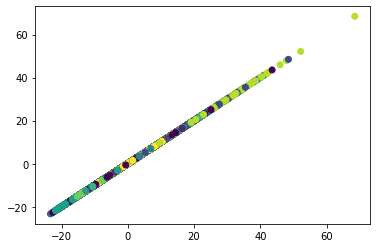

batch size currently : 7500


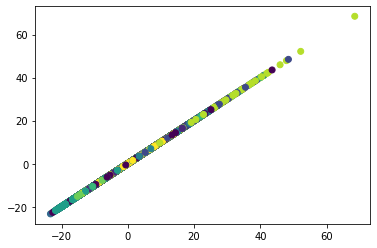

batch size currently : 8000


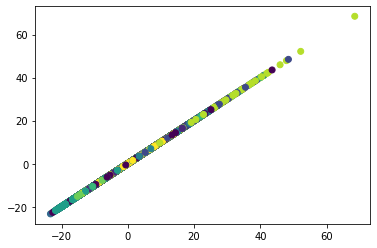

batch size currently : 8500


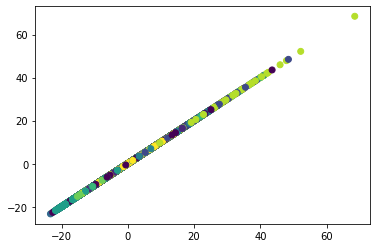

batch size currently : 9000


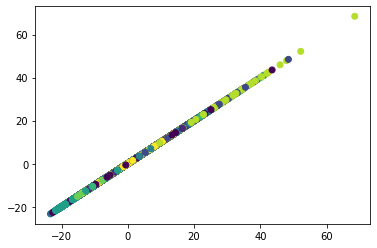

batch size currently : 9500


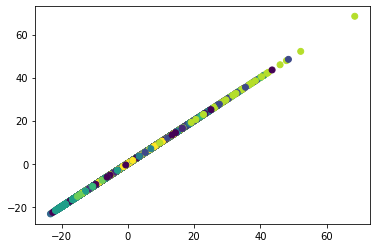

In [28]:
def iteration(R, n:int, temp):
    evector = temp
    for i in range(n):
        w = np.dot(R,evector)
        w_norm = np.linalg.norm(w)
        evector = w/w_norm
    return evector
        

def onlinePowerPCA(R, temp):
    evector = iteration(R, 10, temp)
    eval = np.dot(evector,(np.dot(R,evector)))/np.dot(evector,evector)
    R = R-(eval*np.transpose(evector)*evector)
    return evector, R
    
batch = 100 
standardized_data = StandardScaler().fit_transform(data)
X = standardized_data
X1 = X[:batch]
m = np.mean(X1, axis=0)
#R = np.matmul(X1.T, X1) 
R_online = (X1 - m).T.dot((X1 - m))
evector, R_online = onlinePowerPCA(R_online, np.random.rand(R_online.shape[1]))


for i in range(batch, X.shape[0]):
    x = X[i]
    x_row = (np.transpose(x)*x)
    gam = 1/batch
    m = ((1-gam)*m) + (gam*x_row)
    m_row = x - m
    R_row = np.transpose(m_row)*m_row 
    
    R_online = ((1-gam) * R_online) + (gam * R_row)
    evector1, R_online = onlinePowerPCA(R_online, evector)
    evector2, R_online = onlinePowerPCA(R_online,evector1)
    evector = evector1
    if (i % 500 == 0) : 
        print("batch size currently :",i)
        
        E = np.vstack((evector1,evector2))
        Y=np.matmul(E, X.T)
        #print(Y.shape)
        Y =Y.T
        Y = np.append(Y,label,axis=1)
        pl.scatter(Y[:,0], Y[:,1], c=Y[:,2])
        pl.show()

    batch = batch+i

*Comments:* 

## Part 3. Incremental Power PCA for anomaly detection

Online PCA can be used as an effective tool for stream data outlier detection. Our following
adventure is based on an idea from an article entitled "Anomaly detection via online oversampling principal
component analysis", by Lee et al., in TKDE 25:7.

To start, randomly extract 100 data instances that belong to the "0" class and construct the initial $\mathtt{R}$ matrix.
Carry out batch power PCA and obtain the first eigenvector $\mathtt{e}$.

What follows is we will take a new data point x, and use it to calculate a new covariance matrix
$\mathtt{R1}$ based on $\mathtt{R}$. After obtaining its first eigenvector, denoted by $\mathtt{e1}$, we correlate it with the original eigenvector $\mathtt{e}$. It is expected that a "0" class data point will produce an eigenvector
strongly correlated to $\mathtt{e}$ (with correlation close to 1), while data points of other classes will produce significant deviations (i.e. with correlation close to 0). Hence we can use  a threshold to *test* on each data point and decide whether it is an *anomaly*.  

Note you'll need to keep a copy of the old $\mathtt{R}$ as it is needed for each test. 

To evaluate this outlier detection scheme, we iterate through the dataset:
1. Pick the next data point $\mathtt{x}$.
2. Call $\mathtt{onlinePowerPCA()}$ and obtain the first eigenvector $\mathtt{e1}$.
3. Calculate the correlation between the old and new eigenvectors $\mathtt{e}$ and $\mathtt{e1}$: $\mathtt{corr=e.T*e1}$.
4. Use a threshold on 'corr' so as to decide whether the current input is an outlier.
5. Compare the result with the class labels ($\mathtt{y}$) and collect error statistics such as true positive rate (TPR) and false positive rate (FPR).

**Task 4**. Implement the anomaly detection algorithm. Experiment with different different $\gamma$ and threshold values in the algorithm, and recommend a good parameter setting. (3 marks)

In [53]:
#we are storing labels and data to avoid confusion

_label_ = x # labels
_data_ = y  #data
 


In [56]:
def AnomalyDetection(X): 
    size = X.shape[0]
    mean = np.sum(X, axis = 0 ) /size
    m = X - mean 
    R = np.dot(np.transpose(m), m)
    e,  R = onlinePowerPCA(R,np.random.rand(R.shape[1]))
    index_update = np.random.randint(5000) 
    print("new data's label are : ",_label_[index_update])
    e1 , R1 = onlinePCAanomaly(X, mean, R, e, index_update)  
    correlation = np.abs(np.dot(np.transpose(e), e1)) 
    print("correlation : ",correlation)
  
    if (_label_[index_update] == 0):
        if correlation > threshold: 
            outlier  = False 
        if correlation <= threshold: 
            outlier = True
    else: 
        if correlation > threshold: 
            outlier  = True 
        if correlation <= threshold: 
            outlier = False 
    print("Data point ",index_update," is an outlier :", outlier)
    print("*"*80)
    return _label_[index_update], outlier

def random_selection(): 
    count=0  
    for i in range(x.shape[0]): 
        if (x[i] == 0):
            count= count+1
    indices_0 = np.empty(count, np.uint64)
    zeros = np.empty((count,_data_.shape[1]))
    index =0 
    for i in range(_label_.shape[0]):
        if(_label_[i]==0 ):
            indices_0[index]=i 
            index = index+1  
    for j in range (count):
        zeros[j] = _data_[indices_0[j]]
    np.random.shuffle(zeros)
    data = zeros[:100]
    return data 


def threshold_out(X):
    labels = np.empty(20, np.uint64)
    outliers = []
    for i in range(20):
        l , o = AnomalyDetection(X) 
        labels[i] = l
        outliers.append(o)
    TP = 0
    FP = 0
    TN = 0
    FN = 0 
    for j in range(labels.shape[0]):
        if labels[j] == 0: 
            if outliers[j] >threshold: 
                TP = TP+1 
            else: 
                FN = FN+1 
        else: 
            if outliers[j] < threshold: 
                TN = TN +1 
            else: 
                FP = FP +1 
    
    TPR = (TP/ (TP + FN))
    FPR = (FP/ (FP+TN))
    print ("TPR :", TPR)
    print ("FPR :",FPR)
    
def onlinePCAanomaly(Y, m_online, R_online, evector,pointindex):
    gam =  (1/_data_.shape[0])
    r = _data_[pointindex]
    r_x = (np.transpose(r)*r)  
    m_online= (1-gam)*m_online + (gam * r_x)
    r_m = r - m_online
    r_R = np.transpose(r_m)* r_m 
    R_online= (1-gam)*R_online + (gam * r_R)
    evector1,  R_online = onlinePowerPCA(R_online, evector)
   
    return evector1, R_online 
    
X = random_selection()
threshold = 0.5
threshold_out(X)

new data's label are :  [8]
correlation :  0.001288039081315008
Data point  2343  is an outlier : False
********************************************************************************
new data's label are :  [5]
correlation :  0.0013038583482155516
Data point  2486  is an outlier : False
********************************************************************************
new data's label are :  [3]
correlation :  0.0012915133190700319
Data point  248  is an outlier : False
********************************************************************************
new data's label are :  [5]
correlation :  0.0012967066210305134
Data point  449  is an outlier : False
********************************************************************************
new data's label are :  [2]
correlation :  0.001295810488670281
Data point  658  is an outlier : False
********************************************************************************
new data's label are :  [3]
correlation :  0.0012975313703482844
Data point